In [52]:
import io
from pathlib import Path 
import zipfile
from random import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

figsize(8, 8)

In [53]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [4]:
def load_and_aggregate_truefx(filepaths, timeframe='1h'):
    dfs = []
    for file in tqdm(filepaths):
        df = read_and_parse_truefx(file)
        df = df.resample(timeframe).last().dropna()
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
files = list(datapath.iterdir())
files.sort()
print(len(files))

trn_df = load_and_aggregate_truefx(files[:50], '1h')
tst_df = load_and_aggregate_truefx(files[50: 60], '1h')

125


length:  25183 
                          bid      ask
timestamp                            
2009-05-01 00:00:00  146.130  146.169
2009-05-01 01:00:00  145.952  146.000
2009-05-01 02:00:00  146.120  146.173
2009-05-01 03:00:00  146.110  146.144
2009-05-01 04:00:00  145.910  145.984
length:  5080 
                          bid      ask
timestamp                            
2013-07-01 00:00:00  151.082  151.189
2013-07-01 01:00:00  151.084  151.107
2013-07-01 02:00:00  151.045  151.091
2013-07-01 03:00:00  151.069  151.092
2013-07-01 04:00:00  151.215  151.253


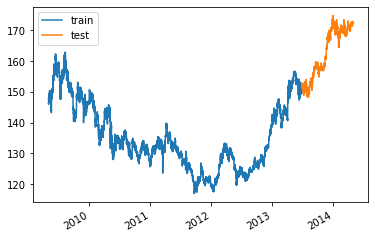

In [8]:
# %matplotlib notebook
%matplotlib inline
print('length: ', len(trn_df), '\n', trn_df.head())
print('length: ', len(tst_df), '\n', tst_df.head())
fig, ax = plt.subplots()
ax.plot(trn_df.mean(axis=1), label='train')
ax.plot(tst_df.mean(axis=1), label='test')
ax.legend()
fig.autofmt_xdate()

In [55]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.mean(axis=1)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.df[idx].to_numpy()

In [236]:
class FixedWindow(torch.utils.data.Dataset):
    def __init__(self, df, window_length):
        self.data = df.to_numpy().astype(np.float32)
#         self.data = df['C'].to_numpy().astype(np.float32)
        self.k = window_length
    def __len__(self):
        return len(self.data) - self.k
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            idx = slice(idx.start+self.k, idx.stop+self.k)
        else:
            idx = idx + self.k
        data = self.data[idx - self.k: idx]
        label = 0
        if random() < 0.5:
            data = data[::-1].copy()
            label = 1
        return torch.from_numpy(data), torch.tensor(label, dtype=torch.float32)

In [237]:
def custom_collate(batch):
    return torch.stack([b[0] for b in batch]), torch.stack([b[1] for b in batch])

In [238]:
from typing import Union
from functools import reduce

act_fn_dict = {'tanhshrink': nn.Tanhshrink, 'relu': nn.ReLU, 'silu': nn.SiLU,
              'gelu': nn.GELU, 'none': lambda: lambda x: x}

class ConvLayerNorm(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        
    def forward(self, x):
        return self.norm(x.transpose(-1, -2)).transpose(-1, -2)
    
class ConvBlock(nn.Module):
    def __init__(self, input_length: int, channels_in: int, channels_out: int, kernel: int, 
                 stride: int, dilation: int, bias: bool, groups: int,
                 padding: Union[int, tuple], maxpool_kernel: int, 
                 act: str, residual: bool = False):
        super().__init__()
        if residual:
            if channels_in != channels_out:
                raise ValueError("channels in must equal channels out if resisudal=True")
        self.residual = residual
        self.conv = conv = nn.Conv1d(channels_in, channels_out,
                         kernel, 
                         stride=stride,
                         dilation=dilation,
                         bias=bias, 
                         groups=groups,
                    )
        if padding is not None:
            self.pad = nn.ReplicationPad1d(padding)
        else:
            self.pad = lambda x: x
        self.act = act_fn_dict[act]()
        self.norm = nn.BatchNorm1d(channels_out)
#         self.norm = lambda x: x
        self.pool = nn.MaxPool1d(maxpool_kernel, stride)
        dummy_input = torch.randn(1, channels_in, input_length)
#         input_length = self.pool(self.pad(self.conv(dummy_input))).shape[-1]
#         self.norm = nn.LayerNorm(input_length)
#         self.norm = ConvLayerNorm(channels_out)
        
    def forward(self, x):
        if self.residual:
            res = x
        x = self.act(self.pad(self.conv(x)))
        x = self.pool(x)
        if self.residual:
            x = res + self.norm(x)
        else:
            x = self.norm(x)
        return x
    
class CNN(nn.Module):
    """
    1D CNN
    """
    def __init__(self, input_size, input_channels, output_size, d_model,
                 channels, kernels, strides, dilations, groups,
                 dropout=0.1, residual_connections=False,
                 act='tanhshrink', bias=False):
        super().__init__()
        assert len(strides) == len(channels) == len(kernels)
        maxpool_kernels = kernels
        self.inp_sz = input_size
        self.out_sz = output_size
        self.d_fc = d_fc
        self.dropout = nn.Dropout(dropout)
        self.act = act_fn_dict[act]()
#         self.act = nn.SiLU()
        bias = bias
        channels = [input_channels] + channels
        layers=[]
        input_length = input_size
        for i in range(1, len(channels)):
#             padding = (kernels[i-1]-1)//2
#             padding = (kernels[i-1]-1, 0)  # causal padding
            padding = None
            _groups=min(max(channels[i-1]//groups, 1), groups)
            print(_groups)
            res = residual_connections if i>1 else False
            conv_block = ConvBlock(input_length,
                                   channels[i-1], channels[i],
                                   kernels[i-1], strides[i-1],
                                   dilations[i-1], bias, _groups,
                                   padding, maxpool_kernels[i-1],
                                   act, res)
            layers.append(conv_block)
            input_length = conv_block(torch.randn(1, channels[i-1], input_length)).shape[-1]
        self.conv_layers = nn.Sequential(*layers)
        self.output_pool = nn.AdaptiveMaxPool1d(d_model)
        self.output_head = nn.Linear(d_model, output_size)
        
    def forward(self, x):
        x = x.transpose(-1, -2)
        x = self.act(self.conv_layers(x))
        x = self.dropout(self.output_pool(x.view(x.shape[0], 1, -1)))
        x = self.output_head(x)
        return torch.sigmoid(x).squeeze()

In [239]:
def model_size(model):
     return reduce(lambda x,y:x+y,
                   [reduce(lambda x,y:x+y, p.shape)
                    for p in model.parameters()])

In [269]:
def trainer(model, dataloader, device, lr=1e-3):
    loss_fn = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print_freq = max(len(dataloader) // 100, 100)
    for i, (x, label) in enumerate(iter(dataloader)):
        opt.zero_grad()
        x = x.to(device)
        pred = model(x)
        loss = loss_fn(pred, label.to(device))
        loss.backward()
        opt.step()
        _loss = loss.detach().item()
        yield _loss
        if i % print_freq == 0:
            print(_loss, end='\r', flush=True)
        
        
@torch.no_grad()
def test(model, dataloader, device):
    loss_fn = nn.MSELoss()
    losses = []
    xs = []
    preds = []
    labels = []
    metrics=[]
    for i, (x, label) in enumerate(iter(dataloader)):
        x = x.to(device)
        pred = model(x)
        loss = loss_fn(pred, label.to(device))
        losses.append(loss.detach().item())
        xs.append(x.cpu().numpy())
        preds.append(pred.cpu().numpy())
        labels.append(label.cpu().numpy())
    
    pred = np.concatenate(preds)
    label = np.concatenate(labels)
    metrics = classification_metrics(pred, label)
    return {'loss': losses, 'x': xs, 'pred': preds, 'label': labels, **metrics}

def classification_metrics(pred, target):
    metrics = {}
    N = len(target)
    pred = np.where(pred > .5, 1., 0.)[0]
    true_pos = target == 1
    true_neg = target == 0
    correct = pred == target
#     assert true_pos + true_neg == correct
#     metrics['tpr'] = true_pos / (target==1)
    metrics['acc'] = (correct).sum() / N
    return metrics
    
        

In [241]:
def show_performance(metrics):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    axs = ax.flatten()
    idx = 0
    for i, _ax in enumerate(axs):
        _ax.plot(metrics['x'][idx][i][:, 0], label='x')
        pred = metrics['pred'][idx][i]
        label = metrics['label'][idx][i]
        _ax.set_title(f'Label: {label}  Pred: {pred: .3f}')
        _ax.legend()
    return fig, ax


In [248]:
window_size = 128
batch_size = 128
d_model = 256
channels = [32, 32]
kernels = [7, 7]
strides = [1, 1]
dilations = [1, 1]
groups = 1

input_channels = 2

encoded_size = 8

trn_dset = FixedWindow(trn_df, window_size)
tst_dset = FixedWindow(tst_df, window_size)
trnloader = torch.utils.data.DataLoader(trn_dset, batch_size=batch_size, shuffle=True,
                                       collate_fn = custom_collate)
tstloader = torch.utils.data.DataLoader(tst_dset, batch_size=batch_size, shuffle=True,
                                       collate_fn = custom_collate)

model = CNN(input_size=64, input_channels=input_channels, output_size=1, d_model=32, channels=channels, 
            kernels=kernels, strides=strides, groups=groups, dilations=dilations).to(device)
print(model_size(model))

1
1
274


In [249]:
# Test forward pass

x, y = next(iter(trnloader))

pred = model(x.to(device))

print(x.shape, pred.shape, y.shape)


torch.Size([128, 128, 2]) torch.Size([128]) torch.Size([128])


In [250]:
losses = []

In [276]:
epochs = 100

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm(range(epochs)):
    train_loop = iter(trainer(model, trnloader, device))
    for loss in train_loop:
        losses.append(loss)
    

0.0013906813692301512


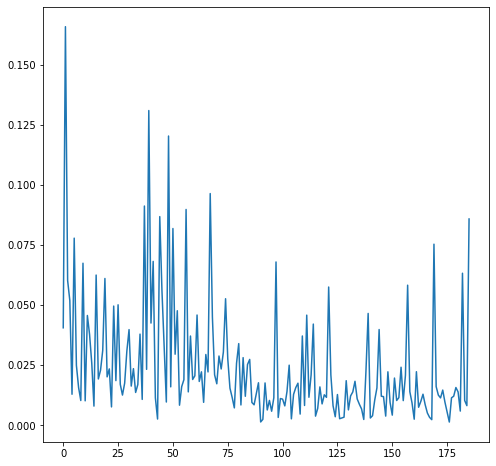

In [277]:
# plt.plot(losses[-len(trnloader)+100:])
plt.plot(losses[-len(trnloader)+10:])

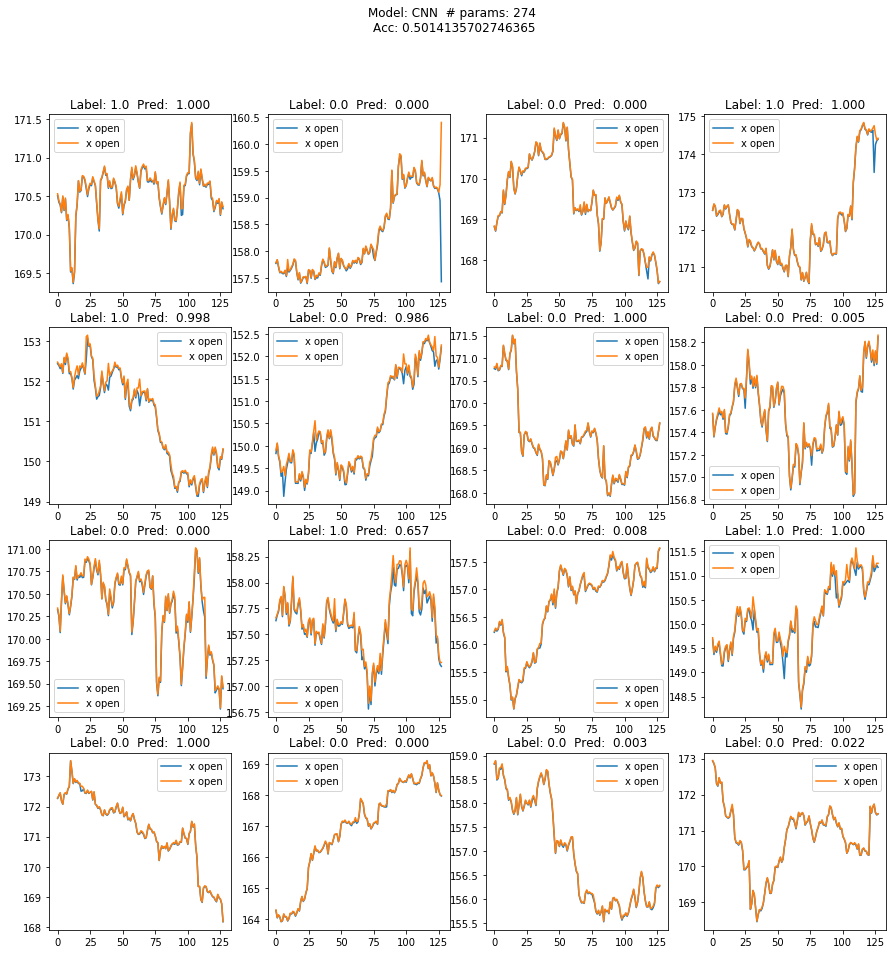

In [278]:
metrics = test(model, tstloader, device)
fig, ax = show_performance(metrics)
title = f'Model: {type(model).__name__}  # params: {model_size(model)} \n' + \
f"Acc: {metrics['acc']}"
_ = fig.suptitle(title)

1